# Can you find a better way to segment your customers?

## 📖 Motivation (Kyra) 
You work for a medical device manufacturer in Switzerland. Your company manufactures orthopedic devices and sells them worldwide. The company sells directly to individual doctors who use them on rehabilitation and physical therapy patients.

Historically, the sales and customer support departments have grouped doctors by geography. However, the region is not a good predictor of the number of purchases a doctor will make or their support needs.

Your team wants to use a data-centric approach to segmenting doctors to improve marketing, customer service, and product planning. 



Questions to answer:
1. How many doctors are there in each region? What is the average number of purchases per region?
2. Can you find a relationship between purchases and complaints?
3. Define new doctor segments that help the company improve marketing efforts and customer service.
4. Identify which features impact the new segmentation strategy the most.
5. Your team will need to explain the new segments to the rest of the company. Describe which characteristics distinguish the newly defined segments.

## Related Work (Michael)

## 💾 The data & Data Wrangling ()

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

#### Doctors contains information on doctors. Each row represents one doctor.
- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

#### Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

#### Complaints collects information on doctor complaints.
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

#### Instructions has information on whether the doctor includes special instructions on their orders.
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

### Setup

In [110]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

### Data

#### Doctors dataframe

In [121]:
doctors = pd.read_csv('data/doctors.csv')
doctors

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.00,0.90,53.85,1.20,49.0
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.00,0.00,100.00,0.00,38.0
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.00,1.53,--,0.00,34.0
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.00,2.03,--,0.48,29.0
4,FJBEA,1 14 T4,Specialist,Ambassador,23.00,0.96,76.79,0.75,24.0
...,...,...,...,...,...,...,...,...,...
432,AIABDJ,1 10,Specialist,Ambassador,2.18,0.80,11.76,0.77,35.0
433,BBAJCF,1 9 T4,Specialist,Ambassador,2.17,1.68,--,0.11,19.0
434,GGCFB,1 19 T4,Specialist,Ambassador,2.14,0.77,--,0.27,22.0
435,FDCEG,1 9,Specialist,Ambassador,2.13,0.84,100.00,0.32,25.0


In [122]:
def transform_rank(rank):
    ###Takes name of doctor's rank and transforms it into ordinal data from 1-9
    if rank == 'Ambassador':
        num_rank = 9
    elif rank == 'Titanium Plus':
        num_rank = 8
    elif rank == 'Titanium':
        num_rank = 7
    elif rank == 'Platinum Plus':
        num_rank = 6
    elif rank == 'Platinum':
        num_rank = 5
    elif rank == 'Gold Plus':
        num_rank = 4
    elif rank == 'Gold':
        num_rank = 3
    elif rank == 'Silver Plus':
        num_rank = 2
    elif rank == 'Silver':
        num_rank = 1
    else:
        num_rank = np.nan
    return num_rank
#apply to doctors dataframe
doctors['Rank'] = doctors['Rank'].apply(transform_rank)
doctors.head()

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,9.0,49.0,0.90,53.85,1.20,49.0
1,ABHAHF,1 8 T4,General Practitioner,9.0,37.0,0.00,100.00,0.00,38.0
2,FDHFJ,1 9 T4,Specialist,9.0,33.0,1.53,--,0.00,34.0
3,BJJHCA,1 10 T3,Specialist,9.0,28.0,2.03,--,0.48,29.0
4,FJBEA,1 14 T4,Specialist,9.0,23.0,0.96,76.79,0.75,24.0


In [123]:
#appears to be 437 total doctors, but not all are represented in each dataframe
print(doctors['DoctorID'].nunique(), orders['DoctorID'].nunique(), complaints['DoctorID'].nunique(), instructions['DoctorID'].nunique())

#367 specialists, 70 GPs
doctors['Category'].value_counts()

#Most are ambassador, with fair amount of platinum, titanium, platinum plus, gold plus, silver plus and few gold, silver or titanium plus
doctors['Rank'].value_counts()

#46 different regions
doctors['Region'].value_counts()
# doctors['Region'].nunique()

doctors.describe()

doctors.dtypes



NameError: name 'orders' is not defined

<AxesSubplot: xlabel='Region', ylabel='count'>

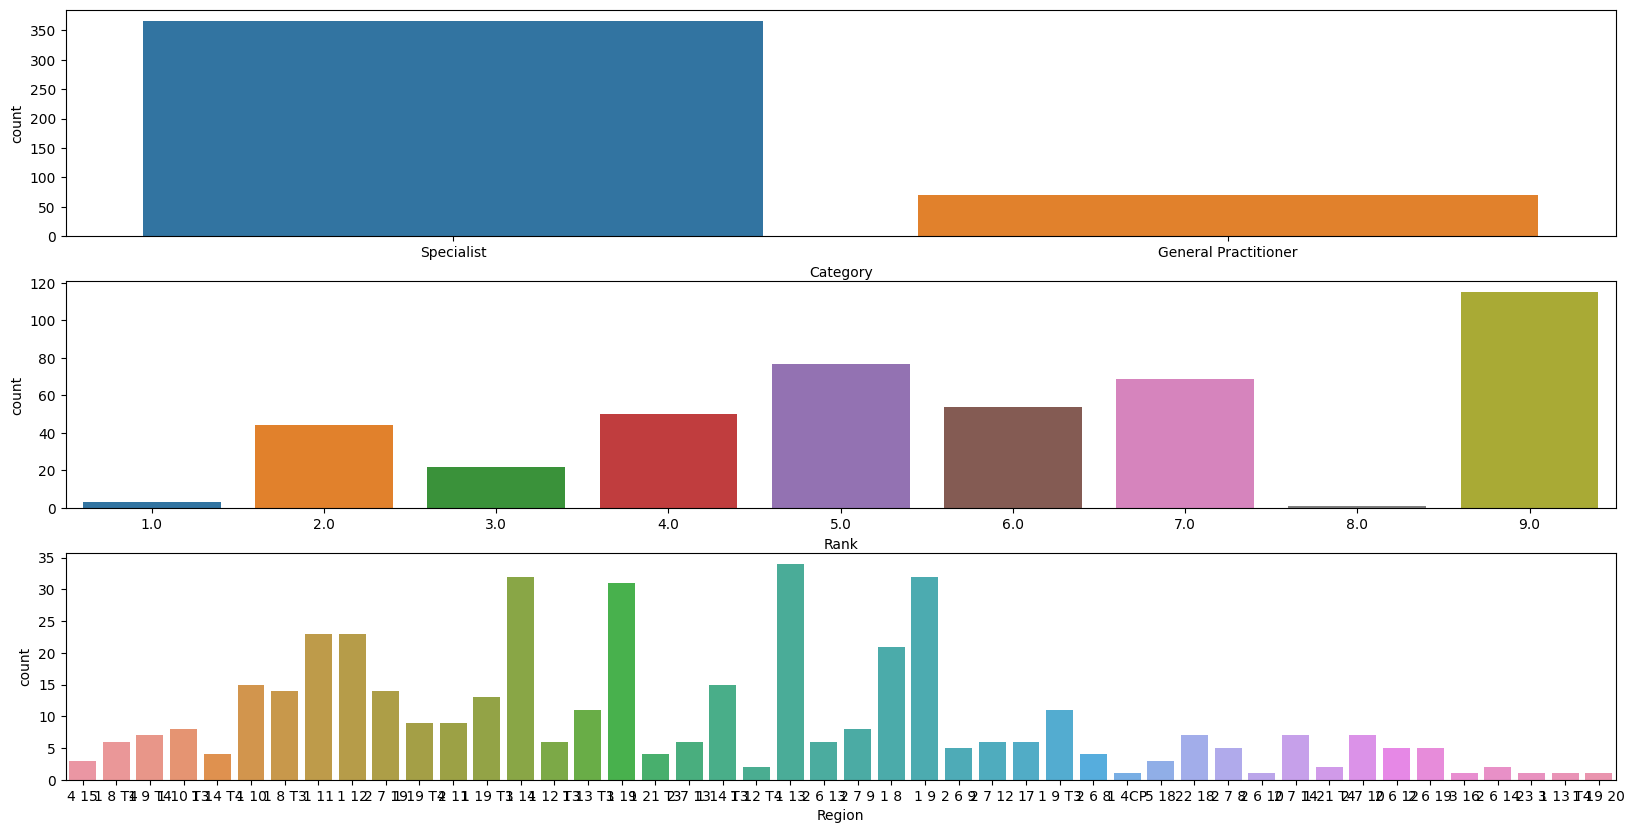

In [124]:
#Visualizing the above. Dunno if quite useful, but good to get an idea of the data nonetheless
f1, axs = plt.subplots(3,1, figsize = (20, 10))
sns.countplot(data = doctors, x = 'Category', ax = axs[0])
sns.countplot(data = doctors, x = 'Rank', ax = axs[1])
sns.countplot(data = doctors, x = 'Region', ax = axs[2])

In [125]:
doctors.isnull().sum()
doctors[doctors['Rank'].isnull() == True]

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
110,BBAHCA,5 18,Specialist,NaN,6.0,3.14,--,1.43,7.0
217,AHABIB,5 18,General Practitioner,NaN,4.0,1.00,83.33,2.00,4.0


##### Calculating average number of doctors and purchases per region:


In [126]:
#Make separate dataframe for just region counts
doc_count = pd.DataFrame(doctors['Region'].value_counts())
doc_count.index.name = 'Region'
doc_count.columns = ['Total Doctors']

#Make separate dataframe for total purchases by region
doc_purch_sum = pd.DataFrame(doctors['Purchases'].groupby(doctors['Region']).sum())
doc_purch_sum.index.name = 'Region'
doc_purch_sum.columns = ['Total Purchases']

#Join two dataframes together 
region_merged = doc_count.merge(doc_purch_sum, how = 'outer', on = 'Region')
region_merged

print(region_merged.head())
print('The mean number of doctors per region is ', region_merged['Total Doctors'].mean(), ' doctors.')
print('The mean number of purchases per region is ', region_merged['Total Purchases'].mean(), ' purchases.')

        Total Doctors  Total Purchases
Region                                
1 13               34            353.0
1 9                32            346.0
1 14               32            389.0
1 19               31            281.0
1 11               23            243.0
The mean number of doctors per region is  9.5  doctors.
The mean number of purchases per region is  102.52173913043478  purchases.


,Total Doctors,Total Purchases
count,46.000000,46.000000
mean,9.500000,102.521739
std,9.008021,107.710670
min,1.000000,5.000000
25%,4.000000,25.250000
50%,6.000000,48.500000
75%,12.500000,149.750000
max,34.000000,389.000000


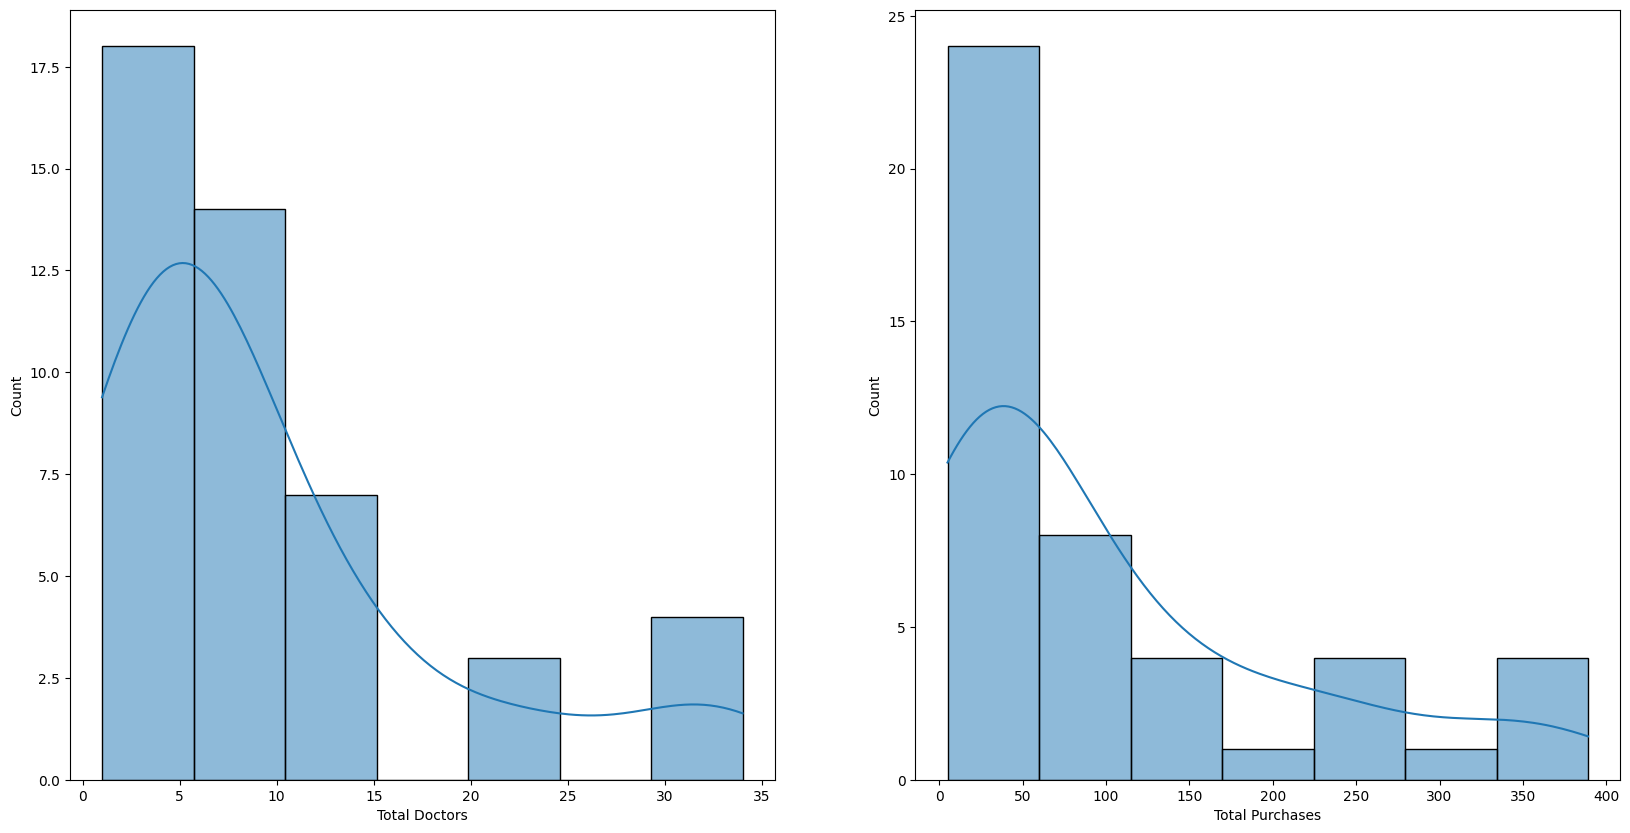

In [127]:
#Let's visualize the distribution of doctors per region
f2, axs = plt.subplots(1, 2, figsize = (20, 10))
sns.histplot(data = region_merged, x = 'Total Doctors', kde= True, ax = axs[0])
sns.histplot(data = region_merged, x = 'Total Purchases', kde= True, ax = axs[1])
region_merged.describe()

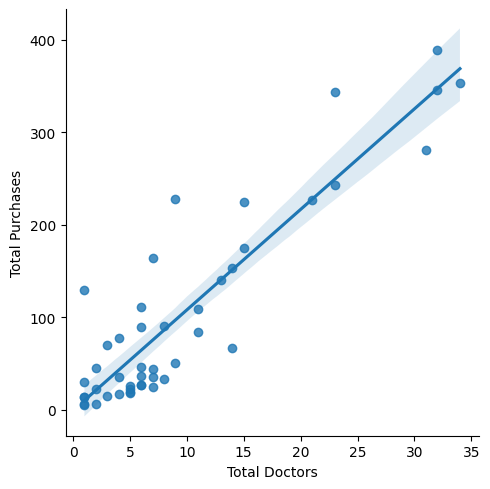

In [128]:
sns.lmplot(data = region_merged, x = 'Total Doctors', y = 'Total Purchases')

#### Orders dataframe

In [5]:
orders = pd.read_csv('data/orders.csv')
orders

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False,NaN
3,EHHGF,DGCDCCF,AIBJJEE,False,False,False,True,False,False,True,False,Before
4,EHHGF,DGCFAGC,AEDBBDC,False,False,False,False,False,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
252,FJFEG,DGDBGJH,AIBCDCE,False,True,False,False,False,True,True,False,Before
253,FJFEG,DGDBGGI,AIBCDGD,False,False,True,False,False,False,True,False,Before
254,FJFEG,DGEABGI,AIBFJHE,True,False,False,False,False,False,False,False,Before
255,FJFEG,DGEABGI,AIBFJHE,True,False,False,True,False,False,False,False,Before


In [78]:
orders['DoctorID'].value_counts()

AAAEAH    19
FAHDI     17
AFCADC    15
FBFHB     14
FAGIE     11
          ..
ADFECC     1
HBAHA      1
GDADF      1
AHDDAI     1
AIABDJ     1
Name: DoctorID, Length: 76, dtype: int64

In [75]:
def conv_to_number(str_in):
    if str_in == True:
        result = 1
    elif str_in == False:
        result = 0
    else:
        result = np.nan
    return result

def condJ_conv_to_number(str_in):
    if str_in == 'Before':
        result = 0
    elif str_in == 'After':
        result = 1
    else:
        result = np.nan
    return result

conditions = ['Condition A', 'Condition B', 'Condition C', 'Condition D', 'Condition F', 'Condition G', 'Condition H', 'Condition I', 'Condition J']
for col in conditions[:-1]:
    orders[col] = orders[col].apply(conv_to_number)

orders['Condition J'] = orders['Condition J'].apply(condJ_conv_to_number)
    
orders.head()

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,0,0,0.0,0,0.0,1.0,1,0,0.0
1,HBIEA,DGAJDAH,AIJIHGB,0,1,NaN,0,0.0,1.0,0,1,0.0
2,GGCCD,DGBBDCB,AFEIHFB,0,0,0.0,0,0.0,0.0,0,0,NaN
3,EHHGF,DGCDCCF,AIBJJEE,0,0,0.0,1,0.0,0.0,1,0,0.0
4,EHHGF,DGCFAGC,AEDBBDC,0,0,0.0,0,0.0,0.0,0,0,NaN


In [76]:
orders.describe()

,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
count,257.000000,257.000000,248.000000,257.000000,254.000000,254.000000,257.000000,257.000000,149.000000
mean,0.128405,0.140078,0.125000,0.132296,0.003937,0.181102,0.284047,0.073930,0.013423
std,0.335193,0.347745,0.331388,0.339473,0.062746,0.385863,0.451839,0.262167,0.115465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Complaints Dataframe

In [4]:
complaints = pd.read_csv('data/complaints.csv')
complaints

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2
...,...,...,...
430,BHGIFC,Incorrect,1
431,BHHDDF,Correct,1
432,CJAFAB,Incorrect,1
433,CAAHID,Correct,2


In [5]:
complaints.dtypes
complaints['Complaint Type'].value_counts()
#complaints.describe()

# complaints['DoctorID'].value_counts().describe()

Correct      205
Incorrect    118
Unknown      103
Specific       6
R&R            1
Name: Complaint Type, dtype: int64

In [6]:
#To answer question need to match up purchases and complaints. We could do this by taking doctors IDs and purchases from doctors dataframe
#and complaint data from complaints. We know that single doctors are listed multiple times for complaints, under different categories. This may 
#be important information to preserve... but how to do that?

# print(complaints['DoctorID'].value_counts())
#We'll start by taking a look at those doctors with multiple entries to see what exactly that means
complaints[complaints['DoctorID'] == 'AAEIEG']

#What I think I need to do is group by doctor and then by complaint type...
comp_group = pd.DataFrame(complaints['Complaint Type'].groupby(complaints['DoctorID']).value_counts())
comp_group
#OK so this got closer to what I was envisioning, but value counts is not the right thing to call here. We need to get the value of Qty in the last column

# comp_group[comp_group['DoctorID'] == 'AAEIEG']
complaints[complaints['DoctorID'] == 'AAEIEG']
complaints.sort_values('DoctorID')

,DoctorID,Complaint Type,Qty
216,AAAEAH,Correct,1
217,AAAHCE,Correct,1
219,AAAHCE,Unknown,1
218,AAAHCE,Incorrect,2
220,AABDHC,Incorrect,1
...,...,...,...
201,IEJIA,Unknown,1
203,IFBHI,Incorrect,1
204,IFBHI,Unknown,1
205,IFDIB,Correct,1


In [25]:
# Since I'm stuck, I'm gonna do it the way I did the previous question and then come back to the above when I have more brainpower
# Except that I can't because there is a numerical value associated with each entry, not just with the category.
### BEGIN PSEUDOCODE, SORRY MICHAEL
#get list of doctor IDS
doc_IDs = complaints['DoctorID'].unique()
doc_IDs
# for ID in doc_IDs:
#     for row in complaints[complaints['DoctorID'] == ID]:
#         if row['Complaint Type'] == 'Correct':
#             #store Qty somehow
#         elif row['Complaint Type'] == 'Incorrect':
#             #store Qty somehow
#         elif row['Complaint Type'] == 'R&R':
#             #store Qty somehow
#         elif row['Complaint Type'] == 'Unknown':
#             #store Qty somehow
#         elif row['Complaint Type'] == 'Specific':
#             #store Qty somehow
#         else:
#             #scream angrily

#Let's test some stuff
doc_IDs[0]   #== 'EHAHI'
row = complaints[complaints['DoctorID'] == 'EHAHI']
print(row)
# row['Complaint Type'][0]
if row['Complaint Type'][0] == 'Correct':
    print('Meow')

# if complaints[
# #for each ID in list, get how many complaints (QTY) of each type (Complaint Type)
# #get these as separate columns in a new dataframe
# complaints[complaints['DoctorID'] == 'AAEIEG']

#what if we can get the sum...
bob = complaints[complaints['DoctorID'] == 'AAEIEG']
steve = bob['Qty'].sum()
print(steve)

  DoctorID Complaint Type  Qty
0    EHAHI        Correct   10
Meow
20


In [81]:
#Get total complaints for each doctor
doc_IDs = list(doc_IDs)
comp_per_doc = pd.DataFrame(doc_IDs)
comp_per_doc.columns = ['DoctorID']
comp_per_doc['Total Complaints'] = 0

for ID in doc_IDs:
    # print(ID)
    temp_df = complaints[complaints['DoctorID'] == ID]
    # print(temp_df)
    total_comp = temp_df['Qty'].sum()
    # print(total_comp)
    index = comp_per_doc.index[comp_per_doc['DoctorID'] == ID].tolist()[0]
    # print(index)
    comp_per_doc.iloc[index, 1] = total_comp

    
comp_per_doc

,DoctorID,Total Complaints
0,EHAHI,10
1,EHDGF,5
2,EHDIJ,13
3,EHDIC,3
4,EHDIH,1
...,...,...
279,BHGIFC,3
280,BHHDDF,1
281,CJAFAB,1
282,CAAHID,2


In [104]:
#Merging with the total purchases per doctor for visualization
comp_plus_purch = comp_per_doc.merge(doctors, how = 'inner', on = 'DoctorID')
comp_plus_purch = comp_plus_purch[['DoctorID', 'Total Complaints', 'Purchases']]
comp_plus_purch

comp_plus_purch.describe()

,Total Complaints,Purchases
count,74.000000,74.000000
mean,3.594595,15.540541
std,3.748676,19.368234
min,1.000000,3.000000
25%,1.000000,5.000000
50%,2.000000,9.000000
75%,5.750000,17.500000
max,20.000000,129.000000


<AxesSubplot: xlabel='Purchases', ylabel='Count'>

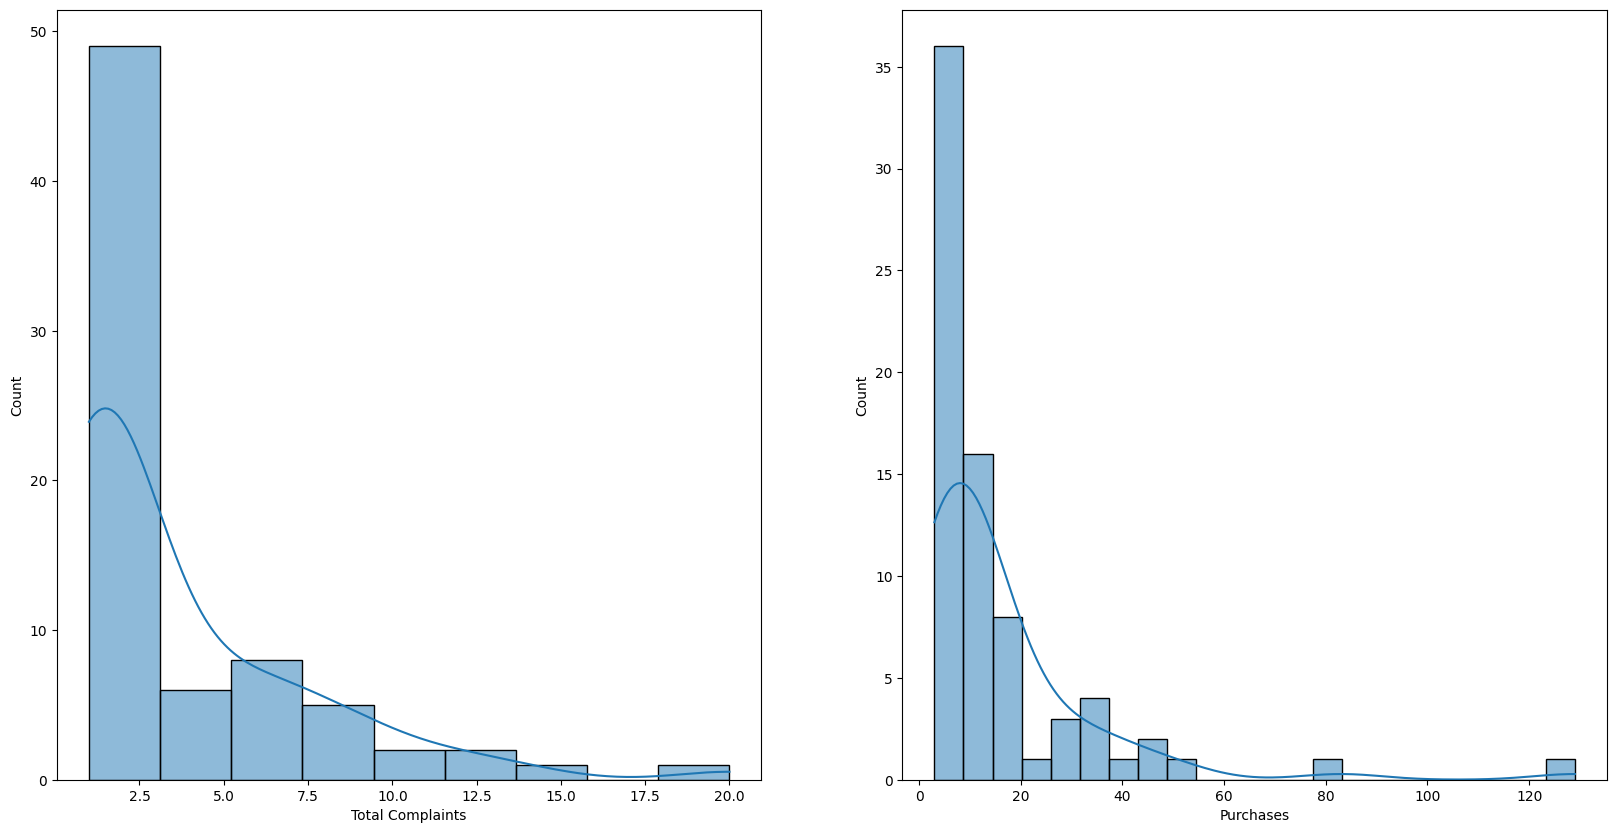

In [128]:
f4, axs = plt.subplots(1, 2, figsize = (20, 10))
sns.histplot(data = comp_plus_purch, x = 'Total Complaints', kde = True, ax = axs[0])
sns.histplot(data = comp_plus_purch, x = 'Purchases', kde = True, ax = axs[1])



In [142]:
# complaints.groupby(complaints['DoctorID'], group_keys = True).GroupBy

#### Instructions dataframe

In [7]:
instructions = pd.read_csv('data/instructions.csv')
instructions

,DoctorID,Instructions
0,ADIFBD,Yes
1,ABHBED,No
2,FJFEG,Yes
3,AEBDAB,No
4,AJCBFE,Yes
...,...,...
72,ABEAFF,Yes
73,FCGCI,Yes
74,FBAHD,Yes
75,FCABB,Yes


In [80]:
instructions['Instructions'].value_counts()
# instructions['DoctorID'].value_counts()

Yes    67
No     10
Name: Instructions, dtype: int64

#### Joining the dataframes together

## Feature Extraction

## EDA

## Clustering

## Results

## Discussion/Conclusion